In [1]:
import sys
from collections import Counter, OrderedDict
import itertools
from itertools import islice, count, groupby
import pandas as pd
import os
import re
from operator import itemgetter
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from time import time
from timeit import timeit
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from google.cloud import storage

import hashlib
def _hash(s):
    return hashlib.blake2b(bytes(s, encoding='utf8'), digest_size=5).hexdigest()

nltk.download('stopwords')

from inverted_index_colab import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!pip install -q pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!pip install -q graphframes

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
graphframes_jar = 'https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar'
spark_jars = '/usr/local/lib/python3.7/dist-packages/pyspark/jars'
!wget -N -P $spark_jars $graphframes_jar


     |████████████████████████████████| 281.3 MB 32 kB/s 
     |████████████████████████████████| 198 kB 56.8 MB/s 
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 155225 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u312-b07-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u312-b07-0ubuntu1~18.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.

In [4]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from graphframes import *

In [5]:
!apt-get update -qq
!apt install openjdk-8-jdk-headless -qq

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 61 not upgraded.


In [6]:
from pathlib import Path
conf = SparkConf().set("spark.ui.port", "4050")
sc = pyspark.SparkContext(conf=conf)
sc.addPyFile(str(Path(spark_jars) / Path(graphframes_jar).name))
spark = SparkSession.builder.getOrCreate()

In [7]:
# Authenticate your user
# The authentication should be done with the email connected to your GCP account
from google.colab import auth
auth.authenticate_user()

In [8]:
# Copy one wikidumps files 
import os
from pathlib import Path
from google.colab import auth

project_id = 'core-period-321814'
!gcloud config set project {project_id}

data_bucket_name = 'wikidata_preprocessed'
try:
    if os.environ["wikidata_preprocessed"] is not None:
        pass  
except:
      !mkdir wikidumps
      !gsutil cp gs://{data_bucket_name}/multistream1_preprocessed.parquet "wikidumps/" 

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey

Copying gs://wikidata_preprocessed/multistream1_preprocessed.parquet...
/ [1 files][316.7 MiB/316.7 MiB]                                                
Operation completed over 1 objects/316.7 MiB.                                    


In [9]:
!mkdir title_bins
!mkdir body_bins
!mkdir anchor_bins

In [10]:
try:
    if os.environ["wikidata_preprocessed"] is not None:
      path = os.environ["wikidata_preprocessed"]+"/wikidumps/*"
except:
      path = "wikidumps/*"

parquetFile = spark.read.parquet(path)


In [9]:
#showing the components of the wikidumps
parquetFile.show(20)

+---+--------------------+--------------------+--------------------+
| id|               title|                text|         anchor_text|
+---+--------------------+--------------------+--------------------+
| 12|           Anarchism|'''Anarchism''' i...|[{23040, politica...|
| 25|              Autism|'''Autism''' is a...|[{492271, Clinica...|
| 39|              Albedo|thumb|upright=1.3...|[{679294, diffuse...|
|290|                   A|'''A''', or '''a'...|[{290, See below}...|
|303|             Alabama|'''Alabama''' () ...|[{351590, Yellowh...|
|305|            Achilles|thumb|260px|Ancie...|[{1076007, potter...|
|307|     Abraham Lincoln|'''Abraham Lincol...|[{1827174, Alexan...|
|308|           Aristotle|'''Aristotle''' (...|[{1389981, bust},...|
|309|An American in Paris|'''''An American ...|[{13066, George G...|
|316|Academy Award for...|The '''Academy Aw...|[{39842, Academy ...|
|324|      Academy Awards|The '''Academy Aw...|[{649481, film in...|
|330|             Actrius|'''''Act

In [14]:
doc_text_pairs_title = parquetFile.limit(1000).select("title", "id").rdd
doc_text_pairs_body = parquetFile.limit(1000).select("text", "id").rdd
doc_text_pairs_anchor_text=parquetFile.limit(1000).select("anchor_text", "id").rdd


### **Building the Index**

First, we will take all the actions we did in assigment3.

***Word_count***- tokenize the words and taking only the words that are not stopwords. 🛑

***reduce_word_count***- A sorting list by the doc 🆔

***calculate_df***- Now we are working on RDD that each element is (word, doc🆔). So we count the document frequency for each word.

***partition_postings_and_write*** - We partitions the partition list
into buckets and write it into the 💾 

In [2]:
english_stopwords = frozenset(stopwords.words('english'))
corpus_stopwords = ['category', 'references', 'also', 'links', 'extenal', 'see', 'thumb']
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)
all_stopwords = english_stopwords.union(corpus_stopwords)


def word_count(text, id):
  tokens = [token.group() for token in RE_WORD.finditer(text.lower())]
  x=dict(Counter(tokens))
  y={}
  for key,val in x.items():
    if key not in all_stopwords:
       y[key]=(id,val)
  
  y=list(y.items())
  return y

def DL(text,id):
  lst_words=[]
  tokens = [token.group() for token in RE_WORD.finditer(text.lower())]
  for i in tokens:
    if i not in all_stopwords:
      lst_words.append(i)
  
  return ((id,len(lst_words)))

def reduce_word_counts(unsorted_pl):
  list_sorted= list(sorted(unsorted_pl,key=itemgetter(0)))
  return list_sorted

def calculate_term_total(postings):
  ''' Takes a posting list RDD and calculate the tt for each token.
  Parameters:
  -----------
    postings: RDD
      An RDD where each element is a (token, posting_list) pair.
  Returns:
  --------
    RDD
      An RDD where each element is a (token, tt) pair.
  '''
  ######################################################################
  # YOUR CODE HERE
  def term_total_count(postingList):
    ttSum = 0
    for pair in postingList:
      ttSum+= pair[1]
    return ttSum
    
  # Return the RDD
  return postings.mapValues(term_total_count)


def calculate_df(postings):
  x=postings.map(lambda x: (x[0],len(x[1])))
  return x

NUM_BUCKETS = 124
def token2bucket_id(token):
  return int(_hash(token),16) % NUM_BUCKETS

def partition_postings_and_write(postings,file_name):
  
  sort_to_buckets=postings.map(lambda x: (token2bucket_id(x[0]),x))
  group_by_buckets= sort_to_buckets.groupByKey()
  list_keys_map_buckets=group_by_buckets.mapValues(list)
  return list_keys_map_buckets.map(lambda x:InvertedIndex.write_a_posting_list(x,file_name))

### ****Indexing The Title****

In [ ]:
#title
word_counts_title = doc_text_pairs_title.flatMap(lambda x: word_count(x[0], x[1]))
postings_title = word_counts_title.groupByKey().mapValues(reduce_word_counts)
#doc lengh
dl=doc_text_pairs_title.map(lambda x:DL(x[0],x[1]))
#postings_title.take(20)
#postings_filtered = postings.filter(lambda x: len(x[1])>10) #we will filter it on the all corpus (will set it to 50


In [ ]:
w2df_title = calculate_df(postings_title)
w2df_dict = w2df_title.collectAsMap()

w2terms = calculate_term_total(postings_title)
dict_term_total = w2terms.collectAsMap()

posting_locs_list_title = partition_postings_and_write(postings_title,'title_bins').collect()

super_posting_locs_title = defaultdict(list)
for posting_loc in posting_locs_list_title:
  for k, v in posting_loc.items():
    super_posting_locs_title[k].extend(v)



In [ ]:
# Create inverted index instance
inverted_title = InvertedIndex()
# Adding the posting locations dictionary to the inverted index
inverted_title.posting_locs = super_posting_locs_title
# Add the token - df dictionary to the inverted index
inverted_title.df = w2df_dict
# Add the total terms
inverted_title.term_total=dict_term_total
# Add the doc lenth
inverted_title.DL=dl.collectAsMap()
# write the global stats out
!mkdir title
inverted_title.write_index('title', 'title_index')

### **Indexing The Body**

In [ ]:
#body
word_counts_of_body = doc_text_pairs_body.flatMap(lambda x: word_count(x[0], x[1]))
postings_body = word_counts_of_body.groupByKey().mapValues(reduce_word_counts)
#doc lengh
dl=doc_text_pairs_body.map(lambda x:DL(x[0],x[1]))
postings_filtered_body = postings_body.filter(lambda x: len(x[1])>10) #we will filter it on the all corpus (will set it to 50)

In [ ]:
w2df_body = calculate_df(postings_filtered_body)
w2df_body = w2df_body.collectAsMap()

w2termsbody = calculate_term_total(postings_filtered_body)
dict_term_total_body = w2termsbody.collectAsMap()

posting_locs_list_body = partition_postings_and_write(postings_filtered_body,'body_bins').collect()

super_posting_locs_body = defaultdict(list)
for posting_loc in posting_locs_list_body:
  for k, v in posting_loc.items():
    super_posting_locs_body[k].extend(v)

In [ ]:
inverted_body = InvertedIndex()
# Adding the posting locations dictionary to the inverted index
inverted_body.posting_locs = super_posting_locs_body
# Add the token - df dictionary to the inverted index
inverted_body.df = w2df_body
#Add the total terms
inverted_body.term_total = dict_term_total_body
# Add the doc lenth
inverted_body.DL=dl.collectAsMap()
# write the global stats out
!mkdir body
inverted_body.write_index('body','body_index')

### **Indexing The Anchor Text**

In [ ]:
anchor=doc_text_pairs_anchor_text.flatMap(lambda x: x[0])
anchor2=anchor.distinct().groupByKey().mapValues(lambda x: " ".join(x))
#anchor2.take(10)

In [ ]:
#anchor_text
word_counts_of_anchor_text = anchor2.flatMap(lambda x: word_count(x[1], x[0]))
postings_anchortext = word_counts_of_anchor_text.groupByKey().mapValues(reduce_word_counts)
#doc lengh
dl_anchor=anchor2.map(lambda x:DL(x[1],x[0]))
#postings_filtered = postings_body.filter(lambda x: len(x[1])>10) #we will filter it on the all corpus (will set it to 50)

In [ ]:
w2df_d = calculate_df(postings_anchortext)
w2df_anchor = w2df_d.collectAsMap()

w2termanchor = calculate_term_total(postings_anchortext)
dict_term_total_anchor = w2termanchor.collectAsMap()

posting_locs_list_anchor = partition_postings_and_write(postings_anchortext,'anchor_bins').collect()

super_posting_locs_anchor = defaultdict(list)
for posting_loc in posting_locs_list_anchor:
  for k, v in posting_loc.items():
    super_posting_locs_anchor[k].extend(v)

In [ ]:
inverted_index_anchor = InvertedIndex()
# Adding the posting locations dictionary to the inverted index
inverted_index_anchor.posting_locs = super_posting_locs_anchor
# Add the token - df dictionary to the inverted index
inverted_index_anchor.df = w2df_anchor
#Add the total terms for each term
inverted_index_anchor.term_total = dict_term_total_anchor
# Add the doc lenth
inverted_index_anchor.DL=dl_anchor.collectAsMap()
# write the global stats out
!mkdir anchor
inverted_index_anchor.write_index('anchor','anchor_index')



**Reading the indexes:**

In [ ]:
read_index_body=InvertedIndex.read_index("body","body_index")
read_index_title=InvertedIndex.read_index("title","title_index")
read_index_anchor_text=InvertedIndex.read_index("anchor","anchor_index")



## **ranking methods:**

We finish with all the indexes.
We create 3 indexes: 
1. Body index
2. Anchor Text Index
3. Title Index

So now we want to checking our functions on them:
The cossine similarity with TF-IDF(based on lecture #3 on the body)

The binary documents on the anchor text and the title.

Ranking the page rank.



## **Preparing**

### **Tokenize:**
The first function we will use is tokenize.
Because all letter in our coropus are low letters, so when will became a query to , we need to lower the letters for each term in the query!  🔡

In addition we don't want stopwords (we remove them in our indexes) 
so we will remove them also from the query 🛑

In [3]:
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)
stopwords_frozen = frozenset(stopwords.words('english'))
def tokenize(text):
    """
    This function aims in tokenize a text into a list of tokens. Moreover, it filter stopwords.
    
    Parameters:
    -----------
    text: string , represting the text to tokenize.    
    
    Returns:
    -----------
    list of tokens (e.g., list of tokens).
    """
    
    list_of_tokens =  [token.group() for token in RE_WORD.finditer(text.lower()) if token.group() not in stopwords_frozen]    
    return list_of_tokens

### **Read posting list**

for each term in the corpus we want to see the postings list of this term.

So this function gave us the posting list by giving a term. 

In [4]:
TUPLE_SIZE = 6
TF_MASK = 2 ** 16 - 1 # Masking the 16 low bits of an integer
from contextlib import closing

def read_posting_list(inverted, w,file_name):
  with closing(MultiFileReader()) as reader:
    locs = inverted.posting_locs[w]
    locs = [(file_name + lo[0], lo[1]) for lo in locs]
    b = reader.read(locs, inverted.df[w] * TUPLE_SIZE)
    posting_list = []
    for i in range(inverted.df[w]):
      doc_id = int.from_bytes(b[i*TUPLE_SIZE:i*TUPLE_SIZE+4], 'big')
      tf = int.from_bytes(b[i*TUPLE_SIZE+4:(i+1)*TUPLE_SIZE], 'big')
      posting_list.append((doc_id, tf))
    return posting_list

Reading the indexes from the drive 

In [15]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
title_index = InvertedIndex.read_index('/content/gdrive/MyDrive/postings/postings_title_without_filter/_title postings_gcp', 'index')
body_index=InvertedIndex.read_index('/content/gdrive/MyDrive/postings/postings_body/postings_gcp_body', 'index')
anchor_index=InvertedIndex.read_index('/content/gdrive/MyDrive/postings/postings_anchor_without_filter/postings_gcp_anchor', 'index')


#### Reading The Page Rank

In [6]:
import pandas as pd 
import json 
import csv

with open('/content/gdrive/MyDrive/postings/page_rank.csv','r') as f:
  reader1=csv.reader(f)
  data=list(reader1)
  dict_pagerank=dict([(int(i),float(j)) for i,j in data])


In [7]:
id_title=pd.read_pickle('/content/gdrive/MyDrive/postings/docid_title.pickle')


### **Checking some statics about them:**
#### Learn The indexes:

1. amount of terms in each index
2. Shows the words that appears most in the of corpus for each index.
3. Show the word that appear in the most of documents in the body


In [19]:
#len of the words
print(len(title_index.term_total))
print(len(body_index.term_total))
print(len(anchor_index.term_total))


1774280
495547
2458241


In [20]:
#Highest amount of a word in all corpus
title_index_most_term=sorted(title_index.term_total.items(),key=lambda x:x[1],reverse=True)[0]
body_index_most_term=sorted(body_index.term_total.items(),key=lambda x:x[1],reverse=True)[0]
anchor_index_most_term=sorted(anchor_index.term_total.items(),key=lambda x:x[1],reverse=True)[0]

print("The word that appears most often in title, body, anchor is:")
print([title_index_most_term,body_index_most_term,anchor_index_most_term])

print("There is something cool from the stats:")
print("Today, evertyhing in our world searches how to develope himself, h")

The word that appears most often in title, body, anchor is:
[('list', 113421), ('new', 6798860), ('new', 951677)]
There is something cool from the stats:
Today, evertyhing in our world searches how to develope himself, h


**There is something cool to learn from the stats:**

Today, evertyhing in our world searches how to develope himself,how to move forward.

Thanks to a our technology, we see a great many new things.
Because we are looking for how to evolve, and less what was in the past, we will move on to new things




In [21]:

#words that appear most in documents in body
body_index_most_df=sorted(body_index.df.items(),key=lambda x:x[1],reverse=True)[0]
body_index_most_df

('external', 2814577)

## **Cosine Similarity**

We will developement 2 functions to this ranking method:

The first is to get the candidates documents for the terms in query.
We will do that with normalized tf-idf, by the given formula from the lectures:
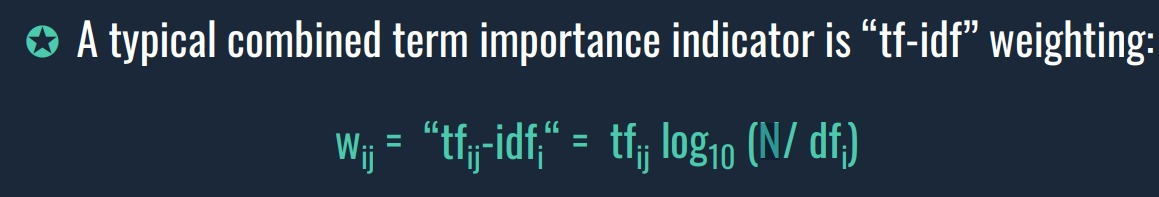


tf (term frequency) normalized by the length of the corpus (the amount of words) multiply by log base 10 on length of the corpus divide by the df in this term.

**The second function** is the second level of the algorithm
Calculating the cosine similarity between query and a doc with 
normalized tf-idf divide by the length of the query * DL- the doc length
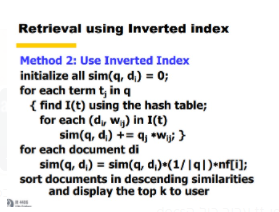


First we will change the dictionary to doc id and title

In [8]:
def change_dict(list_tuples_id_score):
  doc_id_title={}
  for doc_id,score in list_tuples_id_score:
    doc_id_title[doc_id]=id_title[doc_id]
  
  return list(doc_id_title.items())
  

In [28]:
import math
def get_candidate_documents_and_scores(query_to_search,index,path):
    """
    Generate a dictionary representing a pool of candidate documents for a given query. This function will go through every token in query_to_search
    and fetch the corresponding information (e.g., term frequency, document frequency, etc.') needed to calculate TF-IDF from the posting list.
    Then it will populate the dictionary 'candidates.'
    For calculation of IDF, use log with base 10.
    tf will be normalized based on the length of the document.
    
    Parameters:
    -----------
    query_to_search: list of tokens (str). This list will be preprocessed in advance (e.g., lower case, filtering stopwords, etc.'). 
                     Example: 'Hello, I love information retrival' --->  ['hello','love','information','retrieval']

    index:           inverted index loaded from the corresponding files.

    words,pls: generator for working with posting.
    Returns:
    -----------
    dictionary of candidates. In the following format:
                                                               key: pair (doc_id,term)
                                                               value: tfidf score. 
    """
    
    DL=index.DL
    words=list(index.term_total.keys())
    tokens=tokenize(query_to_search)
    query_counter=Counter(tokens)
    query_counterd=dict(query_counter)
    candidates = {}
    N = len(DL)        
    for term in np.unique(tokens):

        if term in words: 

            list_of_doc = read_posting_list(index,term,path)
            normlized_tfidf=[]
            for doc_id, freq in list_of_doc:
              if (doc_id,freq)==(0,0):
                 continue

              formula=(freq/DL[doc_id]) * math.log(N/index.df[term],10) * query_counterd[term]   
              id_tfidf=(doc_id,formula)            
              normlized_tfidf.append(id_tfidf)          
                        
            for doc_id, tfidf in normlized_tfidf:
                candidates[(doc_id,term)] = candidates.get((doc_id,term), 0) + tfidf               
        
    return candidates

In [29]:
def cosine_similarity(search_query, index,path):
    """
    Calculate the cosine similarity for each candidate document in D and a given query (e.g., Q).
    Generate a dictionary of cosine similarity scores 
    key: doc_id
    value: cosine similarity score
    
    Parameters:
    -----------
    D: DataFrame of tfidf scores.

    Q: vectorized query with tfidf scores
    
    Returns:
    -----------
    dictionary of cosine similarity score as follows:
                                                                key: document id (e.g., doc_id)
                                                                value: cosine similarty score.
    """
    
    dict_cosine_sim={}
    candidates = get_candidate_documents_and_scores(search_query, index,path)
    for doc_id_term, normalized_tfidf in candidates.items():
          dict_cosine_sim[doc_id_term[0]] = normalized_tfidf / (len(search_query) * index.DL[doc_id_term[0]])
    
    return dict_cosine_sim


In [32]:
cos_sim=cosine_similarity('python',body_index,'/content/gdrive/MyDrive/postings/postings_body/postings_gcp_body/')
get_top_n1=get_top_n(cos_sim,100)
print(change_dict(get_top_n1))

[(48407627, 'Burmball'), (30796675, 'Python compiler'), (5377129, 'Menpo'), (8005736, 'Rock python'), (57836462, 'Spyce'), (8778894, 'White-lipped python'), (1967274, 'ADODB'), (17940394, 'P. tigris'), (35693777, 'Python europaeus'), (57197811, 'Atrytonopsis python'), (16274121, 'Monty Python Live'), (26147929, 'Ruthvik'), (36349077, 'Simalia clastolepis'), (13584316, 'Kodos Python Regular Expression Debugger'), (18730910, 'Liasis mackloti savuensis'), (28344538, 'PyEphem'), (8573840, 'Webware (disambiguation)'), (35584206, 'CasADi'), (52640649, 'Simalia nauta'), (27319859, 'Carmanor'), (39913402, 'Pydlpoly'), (855019, 'Decorator'), (43626386, 'C. reinhardtii'), (65886986, 'Pytho'), (1046562, 'Woma'), (4137646, 'Cmath'), (13207547, 'Enygrus'), (22322101, 'PySynth'), (24737156, 'Red blood'), (16305806, 'CLPython'), (4378454, 'XRT'), (9678446, 'Heraclides of Aenus'), (9710269, 'Genshi'), (18892555, 'DJL'), (37606161, 'Mayavi (disambiguation)'), (3013633, 'Python (automobile maker)'), (21

Because we are in the body index, you want from us the best 100 results by given a query.


In [31]:
def get_top_n(sim_dict,N=100):
    """ 
    Sort and return the highest N documents according to the cosine similarity score.
    Generate a dictionary of cosine similarity scores 
   
    Parameters:
    -----------
    sim_dict: a dictionary of similarity score as follows:
                                                                key: document id (e.g., doc_id)
                                                                value: similarity score. We keep up to 5 digits after the decimal point. (e.g., round(score,5))

    N: Integer (how many documents to retrieve). By default N = 3
    
    Returns:
    -----------
    a ranked list of pairs (doc_id, score) in the length of N.
    """
    
    dict_sorted= sorted([(doc_id,np.round(score,5)) for doc_id, score in sim_dict.items()], key = lambda x: x[1],reverse=True)[:N]
    return dict_sorted
    

## **Binary Documents For Anchor and Text**  

Returns all the search results from a query list.

When we will see a term from the query in our corpus we will count count it.

We will classify it for each documents the amount of times a term in query appear in his title/ his anchors.


In [33]:
def Binary_Docs(query_to_search, index, file_name):
    
    doc_id_freq = {}
    words=list(index.term_total.keys())
    tokens=tokenize(query_to_search)

    for term in np.unique(tokens):
        if term in words: 

          list_of_doc = read_posting_list(index, term,file_name) 
          for doc_id, freq  in list_of_doc:
              if doc_id in doc_id_freq:
                  doc_id_freq[doc_id] += 1
              else:
                  doc_id_freq[doc_id] = 1
                        
    return sorted(doc_id_freq.items(), key=lambda x: x[1], reverse=True)

In [35]:
NBA=Binary_Docs('NBA',title_index,'/content/gdrive/MyDrive/postings/postings_title_without_filter/_title postings_gcp/')[:100]
print(NBA)

[(22092, 1), (213483, 1), (278018, 1), (404020, 1), (450389, 1), (516570, 1), (631870, 1), (631964, 1), (671992, 1), (715940, 1), (737534, 1), (748251, 1), (751668, 1), (752314, 1), (753474, 1), (758411, 1), (786372, 1), (809525, 1), (835946, 1), (890793, 1), (899781, 1), (987153, 1), (1109042, 1), (1156963, 1), (1159770, 1), (1163174, 1), (1203292, 1), (1277423, 1), (1305847, 1), (1385825, 1), (1403349, 1), (1473882, 1), (1478712, 1), (1531584, 1), (1621889, 1), (1625381, 1), (1683298, 1), (1694635, 1), (1716109, 1), (1788981, 1), (1788982, 1), (1788983, 1), (1788986, 1), (1788988, 1), (1788990, 1), (1811320, 1), (1811390, 1), (1858899, 1), (1890933, 1), (1891771, 1), (1892672, 1), (1956255, 1), (1977405, 1), (2043375, 1), (2065125, 1), (2065129, 1), (2065134, 1), (2065141, 1), (2065145, 1), (2065147, 1), (2065150, 1), (2065157, 1), (2065175, 1), (2065180, 1), (2065184, 1), (2065185, 1), (2065188, 1), (2065189, 1), (2065193, 1), (2065195, 1), (2066890, 1), (2080104, 1), (2110825, 1), 

## **Page Rank Method**  


In [36]:
def page_rank(wiki_id,page_rank_dict):
  lst_pagerank=[]
  for wikiid in wiki_id:
    if wikiid in list(page_rank_dict.keys()):
      lst_pagerank.append((wikiid,page_rank_dict[wikiid]))
  
  return lst_pagerank


## **Page Views Method**  


Taking a pkl file from the drive that we creaye in homework 1

In [37]:
page_viewsdict=pd.read_pickle('/content/gdrive/MyDrive/postings/pageviews-202108-user.pkl')

In [38]:
def page_views(wiki_id,page_rank_dict):
  lst_pageviews=[]
  for wikiid in wiki_id:
    if wikiid in list(page_rank_dict.keys()):
      lst_pageviews.append((wikiid,page_rank_dict[wikiid]))
  
  return lst_pageviews

### ***Doing Some Tests on the ranking methods***

An example of showing wiki page of one of our results:

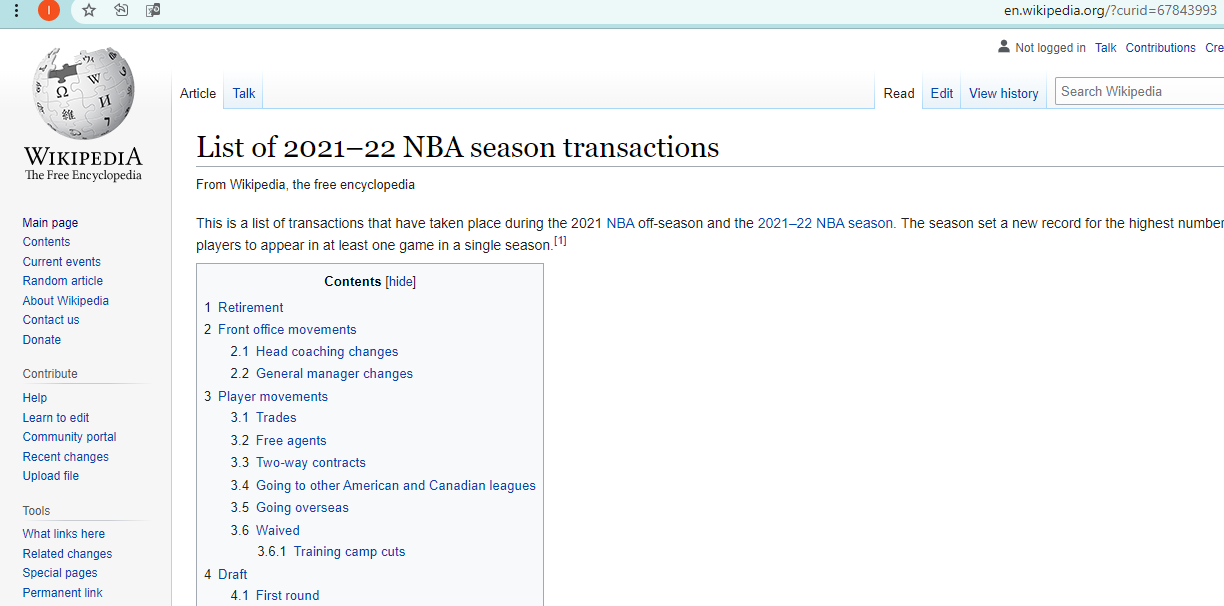

**For id- 67843993** 🏀

We can see all the trades in the nba in the summer of 2021-22 season.
By the way 🙂, our former Israeli player Omri Casspi have shown in this page because retired player that played in the NBA insert to "transaction list"

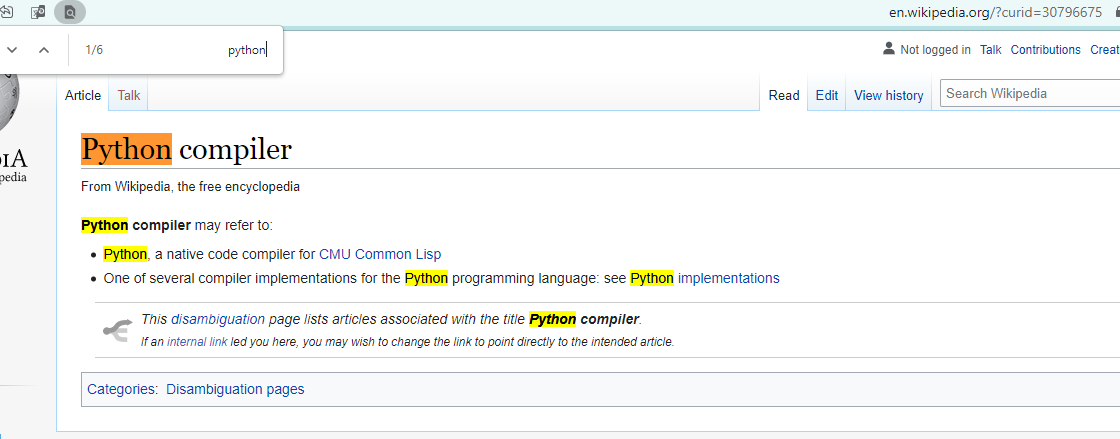

First we can see that the we didn't refer to the stopwords in the query.

We take the second doc with the second highest cosine similarity and we want to see why.

In this document we can see that there are very small amount of words, and the words python is appear a lot in the proportion of the amount terms of this documents.

As a result the score will be high.

#### **Testing Page Rank**

In [41]:
page_rank([3434750,25,12],dict_pagerank)

[(3434750, 9913.728782160777),
 (25, 59.44359172598919),
 (12, 147.6714763991627)]

In [43]:
#print the highest page rank score for wiki id
sorted(dict_pagerank.items(),key=lambda x:x[1],reverse=True)[0]


(3434750, 9913.728782160777)

The page with the highest page rank score is USA.
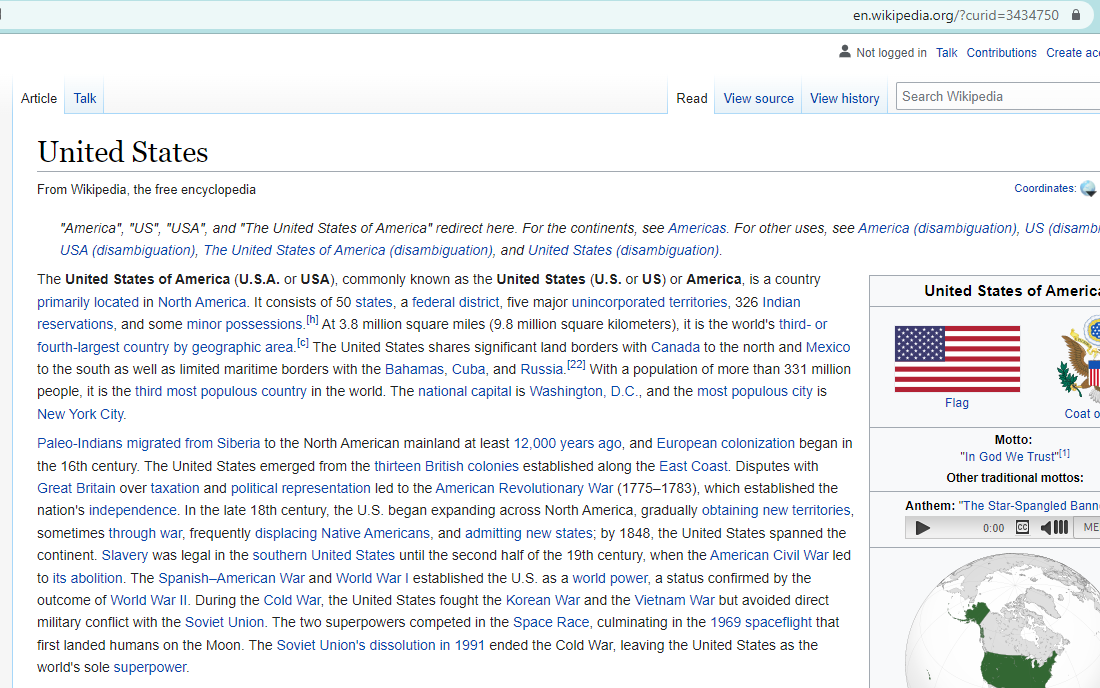


**Testing The Page Views**

In [44]:
page_views([12,23,22092,278018],page_viewsdict)

[(12, 75195), (23, 1), (22092, 560), (278018, 11818)]

In [46]:
#print the mpage with max views
max_views=sorted(page_viewsdict.items(),key=lambda x:x[1],reverse=True)
print(max_views[0])

(15580374, 181126232)


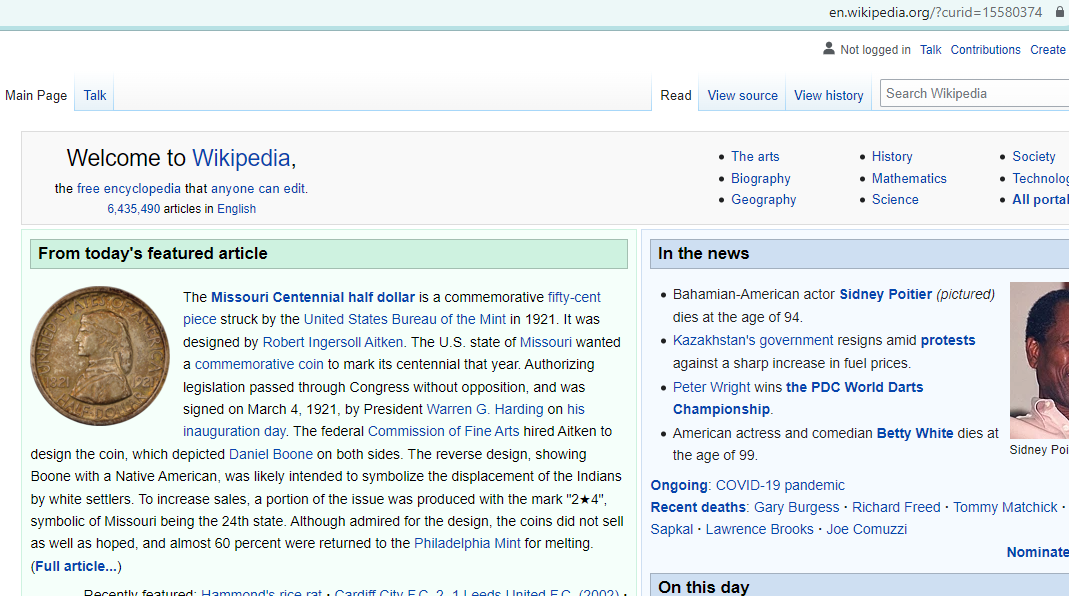

###**Different search methods that we try**

First Try:
we want to give different weights to each index.
Because the importance of the body we give him the heighest weight-(100-i) * 0.7, to the title-(100-i) * 0.2, to the anchor text-(100-i) * 0.1, when i is index that run from 0 to 100.


After that we merge the best 100 results (after a sortion by their weights).

In [49]:
def search(query_to_search,body_index,title_index,anchor_index,page_view,page_rankdict):

  #We will give to the body, anchor and title different weights:
  #to the body We will give 0.70
  # To the title we will give 0.2
  # To the anchor we will give 0.1

  cos_sim=cosine_similarity(query_to_search,body_index,'/content/gdrive/MyDrive/postings/postings_body/postings_gcp_body/')
  top_nbody=get_top_n(cos_sim,100)

  title_binary=Binary_Docs(query_to_search,title_index,'/content/gdrive/MyDrive/postings/postings_title_without_filter/_title postings_gcp/')[:70]
  anchor_binary=Binary_Docs(query_to_search,anchor_index,'/content/gdrive/MyDrive/postings/postings_anchor_without_filter/postings_gcp_anchor/')[:20]

  dict_id_score={}
  lst_docs=[]
  i=0
  while len(lst_docs) < 100:
      body=(100-i)*0.7
      title=(100-i)*0.2
      anchor=(100-i)*0.1
      lst=[body,title,anchor]

      index_max=lst.index(np.max(lst))

      if index_max==0:
        if top_nbody[i][0] in lst_docs:
          continue
        else:
          lst_docs.append(top_nbody[i][0])
          

      if index_max==1:
        if title_binary[i][0] in lst_docs:
          continue
        else:
          lst_docs.append(title_binary[i][0]) 
          


      if index_max==2:
        if anchor_binary[i][0] in lst_docs:
          continue
        else:
          lst_docs.append(anchor_binary[i][0]) 
          

      i+=1
     
  #print(lst_docs)
  # #now how to return the order of the docs: about the views or about the page rank
  # #we weight to each ranking:
  # #to the page rank we will give 0.7 and to the page views 0.3
  dict_docid_score_page_rank=dict(page_rank(lst_docs,page_rankdict))
  
  dict_sorted= sorted([(doc_id,np.round(score,5)) for doc_id, score in dict_docid_score_page_rank.items()], key = lambda x: x[1],reverse=True)
  
  final_docs=change_dict(dict_sorted)

  return final_docs
  










We put it on the colab to running the app with this method and our map@40 is 0.11 and the average running is 5 sec .

Bad results

### **BM25 Score**

We implement 3 functions that based on homework 4:

1. **BM25_score_docid_query**- Based on the formula in the lecture. For given a query we calculate bm25 score for each doc id that have terms in the query, else: is 0.

2. **calc_idf**- calculate the idf bm25 score for a query.

3. **BM25_search_body3** - the main function that to gives the list of relevantive docs to BM25 score and sorted them from the highest to lowest by their scores.


In [9]:
import math

def BM25_search_body3(queries,N=100):
    avg_doc_length_of_all_corpus = sum(body_index.DL.values()) / len(body_index.DL)
    size_corpus = len(body_index.DL)
    tokens=tokenize(queries)
    all_docs_distinct = []
    term_docid_freq = {}
    
    
    for term in tokens:
            
            if term in body_index.term_total:
              list_docid_tf_foreach_term = read_posting_list(body_index, term,'/content/gdrive/MyDrive/postings/postings_body/postings_gcp_body/')
              lst_docid=[]

              for doc_id,freq in list_docid_tf_foreach_term:
                  term_docid_freq[(term, doc_id)] = freq
                  lst_docid.append(doc_id)
              
              all_docs_distinct+=lst_docid

    all_docs_distinct= set(all_docs_distinct)

    def BM25_score_docid_query(query, doc_id,k1=1.5, b=0.75):
  
        idf = calc_idf(query)
        bm25 = 0
        for term in query:
            if (term,doc_id) in term_docid_freq:
                freq=term_docid_freq[(term,doc_id)]
                first=(k1+1)* freq
                secondpart=query[term] * idf[term]
                thirdpart=freq + k1 * (1 - b + b * (body_index.DL[doc_id] / avg_doc_length_of_all_corpus))
                                                      
                bm25 += secondpart * (first  / thirdpart)
        return bm25

    def calc_idf(query):
        
        idf = {}
        for term in query:
            if term not in body_index.term_total.keys():  
                idf[term] = 0
            else:

                mone= size_corpus - body_index.df[term] + 0.5
                mechane=body_index.df[term] + 0.5 + 1
                idf[term] = math.log((mone / mechane)+1)
            
        return idf

    doc_id_bm25=[]
    for doc_id in all_docs_distinct:
        doc_id_bm25.append((doc_id,BM25_score_docid_query(dict(Counter(tokens)),doc_id,1.5,0.75)))
    
    doc_id_bm25=sorted(doc_id_bm25, key=lambda x: x[1], reverse=True)[:100]
    
    res=change_dict(doc_id_bm25)
    
    return res
    
    

## **Tests**

In [12]:
y=BM25_search_body3('PYTHON', N=100)
x=BM25_search_body3('Omri Casspi', N=100)

In [11]:
print(y)

[(13213953, 'List of pythonid species and subspecies'), (46332325, 'Python'), (696712, 'Python Software Foundation'), (1255122, 'List of Monty Python projects'), (18805500, 'Python for S60'), (21356332, 'History of Python'), (25061839, 'Core Python Programming'), (3673376, 'List of Python software'), (24193838, 'Setuptools'), (58429169, 'Tim Peters (software engineer)'), (23862, 'Python (programming language)'), (3274540, 'Pyrex (programming language)'), (5087621, 'Python License'), (21727049, 'Py2exe'), (21965279, 'Python Server Pages'), (46448252, 'Zen of Python'), (8005736, 'Rock python'), (24193668, 'Python Package Index'), (1996367, 'Comparison of web template engines'), (57197811, 'Atrytonopsis python'), (16305806, 'CLPython'), (4920126, 'Python (genus)'), (30714017, 'PyScripter'), (2009536, 'Stackless Python'), (1984246, 'CPython'), (2032271, 'Python molurus'), (49119569, 'Comparison of deep-learning software'), (3596573, 'Python Software Foundation License'), (639888, 'Colt Pyt

In [13]:
print(x)

[(24853361, 'Elitzur Yavne B.C.'), (13601114, 'Omri Casspi'), (27744844, '2010–11 Sacramento Kings season'), (41035105, 'Omri (disambiguation)'), (23285805, '2009–10 Sacramento Kings season'), (42987581, '2014–15 Sacramento Kings season'), (9088145, 'Caspi'), (41387862, '2013–14 Houston Rockets season'), (54194946, 'Israeli Basketball Premier League Sixth Man of the Year'), (53886239, 'Akilan Pari'), (46928945, '2015–16 Sacramento Kings season'), (41682206, '2006 Euroleague Final Four'), (17508177, '2007–08 Israeli Basketball Super League'), (34848153, "Ze'ev Casspi"), (57430776, '2018–19 Memphis Grizzlies season'), (31775276, '2011–12 Cleveland Cavaliers season'), (54083191, '2017–18 Golden State Warriors season'), (60295571, 'Netanel Artzi'), (22798, 'Omri'), (6432635, 'Omrides'), (725810, 'The Indian in the Cupboard'), (5094131, 'The Indian in the Cupboard (film)'), (46179725, 'Inta Omri'), (7233082, 'Israeli Basketball Premier League'), (3604155, 'Leon Rose'), (67254890, '2021–22 N

Looking Good !

## **Running On The App**

The results from this method !
So 🙂 to see those results. Hard work pays off. 

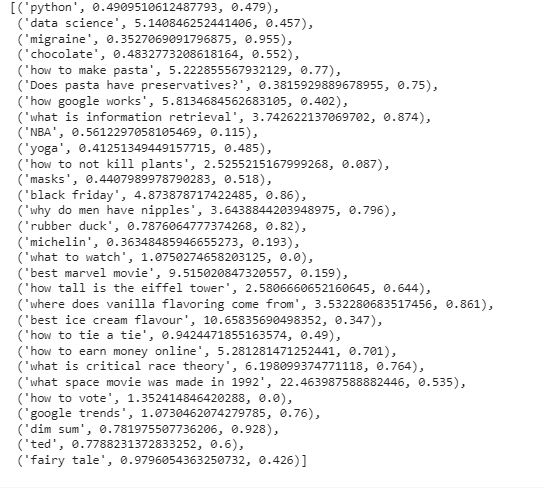